### Computer Vision Final Exam

## Mesyella-2201793281

### 5. Face Detection Algorithm using HOG features and SVM

### Import library

Import python library needed to create the algorithm

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage import data, color, feature
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

### a. Build Dataset

I built a dataset containing 10 face images (positive images) and 30 non-face images (negative images). The resource for the image is from Pinterest. I put the label for non-face is 0 and face is 1.

In [2]:
train_paths = []
labels = []
test_paths = []
for name in os.listdir("Dataset_P5/non-face"):
    image_path = os.path.join("Dataset_P5/non-face", name)
    train_paths += [image_path]
    labels += [0]
    
for name in os.listdir("Dataset_P5/face"):
    image_path = os.path.join("Dataset_P5/face", name)
    train_paths += [image_path]
    labels += [1]

### b. Extract HOG Features and train using linear SVM

#### HOG Features

After read the image, I extract the HOG feature of the training dataset using skimage library.

In [3]:
hog= []
images = []
for i, path in enumerate(train_paths):
    im = cv2.imread(path,0)
    resized_img = resize(im, (120, 100))
    images.append(resized_img)
    hog.append(feature.hog(resized_img))
hog = np.array(hog)

#### Linear SVM

Then the HOG feature of the train dataset will be the input of the model. The model used for this algorithm is linear support support vector machine from scikit-learn (LinearSVC).

In [4]:
model = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
model.fit(hog, labels)
print('accuracy' + str(model.best_score_))

accuracy1.0


The accuracy for the training is 100%

### c. Test the model using sliding window

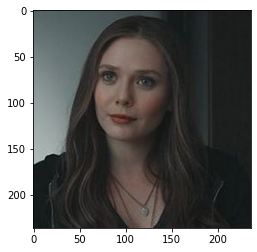

In [5]:
test_image = cv2.imread("Dataset_P5/test.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
plt.imshow(test_image)

#### Sliding window

Create a window that iterates over patches of the test image. Then extract the HOG feature of the patches.

In [6]:
def sliding_window(img):
    x, y = (int(1.0 * s) for s in (120, 100))
    for i in range(0, img.shape[0] - x, 2):
        for j in range(0, img.shape[1] - x, 2):
            patch = img[i:i + x, j:j + y]
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(3364, 10530)

Using the SVM model, evaluate the HOG feature of the patches.

In [7]:
labels = model.predict(patches_hog)
labels.sum()

110

Here I found 110 detection which are 110 overlapping windows surrounding the test image.

### Show overlapping windows

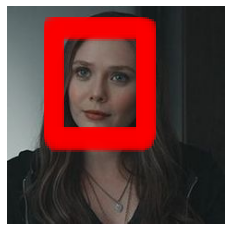

In [8]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = images[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

### Remove overlapping windows using Non max supression

First I collect all the windows and put them in one array

In [9]:
windows = []
for i, j in indices[labels == 1]:
    windows.append([j,i,Nj+j,Ni+i])
windows = np.array(windows)

#### Non max supression function

First compute the area of the bounding boxes and sort them by the bottom right coordinate. Then grab the last index and add the value to result list and initialize the deleted list using the last index. After that loop all index in the index list and find the start of the largest coordinate and the end of the smallest coordinate to create a new bounding box. Then check the difference of the new bounding box and the bounding box in area list. If the difference is bigger than the threshold, delete the bounding box. Do all of the steps for all index list

In [10]:
def nms(windows, thresh):
    res = []
    x1 = windows[:,0]
    y1 = windows[:,1]
    x2 = windows[:,2]
    y2 = windows[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    ind = np.argsort(y2)   
    while len(ind) > 0:
        last = len(ind) - 1
        i = ind[last]
        res.append(i)
        delete = [last]
        for pos in range(0, last):
            j = ind[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            diff = float(w * h) / area[j]
            if diff > thresh:
                delete.append(pos)
        ind = np.delete(ind, delete)
    return windows[res]

### Show the result after non maximum supression

The threshold used for the supression is 0.5 and show a good result for the face detection

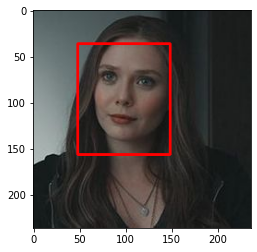

In [11]:
result = nms(windows, 0.5)
for (startX, startY, endX, endY) in result:
    cv2.rectangle(test_image, (startX, startY), (endX, endY), (255, 0, 0), 2)

plt.imshow(test_image, cmap='gray')

Resource: 
https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html

https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/